# Face Identification

Output vector: **16** x float32  
Dataset size: **100** / 2194  
IPU: **x2**  

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
fcnt = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        fcnt += 1
        if fcnt < 10 or fcnt > 2190:
            print(os.path.join(dirname, filename))
print(fcnt)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/torchvision-resnet-pretrained/resnet101-63fe2227.pth
/kaggle/input/torchvision-resnet-pretrained/resnet101-cd907fc2.pth
/kaggle/input/torchvision-resnet-pretrained/resnet152-394f9c45.pth
/kaggle/input/torchvision-resnet-pretrained/resnet152-f82ba261.pth
/kaggle/input/torchvision-resnet-pretrained/resnet18-f37072fd.pth
/kaggle/input/torchvision-resnet-pretrained/resnet34-b627a593.pth
/kaggle/input/torchvision-resnet-pretrained/resnet50-0676ba61.pth
/kaggle/input/torchvision-resnet-pretrained/resnet50-11ad3fa6.pth
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full.csv
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_4/youtube_faces_with_keypoints_full_4/Yuri_Fedotov_2.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_4/youtube_faces_with_keypoints_full_4/Yuri_Fedotov_3.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_4/youtube_face

In [2]:
!df /kaggle/

Filesystem     1K-blocks     Used Available Use% Mounted on
overlay        104802308 52100952  52701356  50% /


In [3]:
!mkdir -pv /kaggle/temp
!rm -Rf /kaggle/temp/*
!cp -as /kaggle/input/youtube-faces-with-facial-keypoints /kaggle/temp/
!mv /kaggle/temp/youtube-faces-with-facial-keypoints/*/*/*.npz /kaggle/temp/youtube-faces-with-facial-keypoints/
!ls /kaggle/temp/youtube-faces-with-facial-keypoints/ | wc

mkdir: created directory '/kaggle/temp'
   2199    2199   45153


In [4]:
data_dir = '/kaggle/temp/youtube-faces-with-facial-keypoints'

In [5]:
# Updating to the recent pretrained data
!rm -Rf ~/.cache/torch/hub/checkpoints/
!mkdir -pv ~/.cache/torch/hub/checkpoints/
!cp -avs /kaggle/input/torchvision-resnet-pretrained/resnet*.pth ~/.cache/torch/hub/checkpoints/
!cp -vsf ~/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth ~/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
!cp -vsf ~/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth ~/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
!cp -vsf ~/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth ~/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
!ls -l ~/.cache/torch/hub/checkpoints/

mkdir: created directory '/root/.cache/torch'
mkdir: created directory '/root/.cache/torch/hub'
mkdir: created directory '/root/.cache/torch/hub/checkpoints/'
'/kaggle/input/torchvision-resnet-pretrained/resnet101-63fe2227.pth' -> '/root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet101-cd907fc2.pth' -> '/root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet152-394f9c45.pth' -> '/root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet152-f82ba261.pth' -> '/root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet18-f37072fd.pth' -> '/root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet34-b627a593.pth' -> '/root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth'
'/kaggle/input/torchvision-resnet-pretrained/resnet50

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
df = pd.read_csv(f'{data_dir}/youtube_faces_with_keypoints_full.csv')
df = df[:100]
df

,videoID,personName,imageHeight,imageWidth,videoDuration,averageFaceSize,numVideosForPerson
0,Alison_Lohman_0,Alison_Lohman,228.0,213.0,240.0,90.150000,6.0
1,Alison_Lohman_1,Alison_Lohman,248.0,201.0,79.0,108.417722,6.0
2,Alison_Lohman_2,Alison_Lohman,335.0,308.0,136.0,122.161765,6.0
3,Alison_Lohman_3,Alison_Lohman,151.0,110.0,53.0,58.000000,6.0
4,Alison_Lohman_4,Alison_Lohman,236.0,228.0,147.0,91.680272,6.0
...,...,...,...,...,...,...,...
95,Paul_Bremer_2,Paul_Bremer,288.0,277.0,193.0,129.471503,5.0
96,Paul_Bremer_3,Paul_Bremer,339.0,271.0,50.0,166.000000,5.0
97,Paul_Bremer_4,Paul_Bremer,269.0,227.0,240.0,120.316667,5.0
98,Paul_Bremer_5,Paul_Bremer,228.0,245.0,240.0,106.866667,5.0


In [8]:
import poptorch
poptorch.ipuHardwareIsAvailable(num_ipus=1), poptorch.ipuHardwareIsAvailable(num_ipus=16), poptorch.ipuHardwareIsAvailable(num_ipus=32)

(True, True, False)

In [9]:
!mkdir -p /tmp/work/popcache
popcache_dir = '/tmp/work/popcache'
hw_emulation = False
ipu_id = 16 # x2
#ipu_id = 24 # x4
#ipu_id = 28 # x8
#ipu_id = 30 # x16

In [10]:
import torch
import torch.nn as nn
#import torch.optim as optim
import poptorch.optim as optim
import torchvision
from torchinfo import summary

In [11]:
import PIL
import cv2

class NormalizeTransform:
    def __init__(self, ratio=0.333):
        self.ratio = ratio

        self.jawPoints          = [ 0,17]
        self.rigthEyebrowPoints = [17,22]
        self.leftEyebrowPoints  = [22,27]
        self.noseRidgePoints    = [27,31]
        self.noseBasePoints     = [31,36]
        self.rightEyePoints     = [36,42]
        self.leftEyePoints      = [42,48]
        self.outerMouthPoints   = [48,60]
        self.innerMouthPoints   = [60,68]

        self.norm_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.functional.autocontrast,
            torchvision.transforms.functional.to_grayscale,
            torchvision.transforms.ToTensor(),
        ])

    def __call__(self, data, landmarks):
        data = self.face_transform(data, landmarks)
        img = PIL.Image.fromarray(data)
        data = self.norm_transform(img)
        return data

    def face_transform(self, data, landmarks):
        # see FaceId-Normalization.ipynb
        pt1 = self.avg(landmarks[self.leftEyePoints[0]:self.leftEyePoints[1]])
        pt2 = self.avg(landmarks[self.outerMouthPoints[0]:self.outerMouthPoints[1]])
        pt3 = self.avg(landmarks[self.rightEyePoints[0]:self.rightEyePoints[1]])
        src_pts = np.float32([pt1, pt2, pt3])
        dst_pts = np.float32([
            [data.shape[0]*self.ratio, data.shape[1]*self.ratio],
            [data.shape[0]/2, data.shape[1]*(1-self.ratio)],
            [data.shape[0]*(1-self.ratio), data.shape[1]*self.ratio]
        ])
        M = cv2.getAffineTransform(src_pts, dst_pts)
        data = cv2.warpAffine(data, M, data.shape[:2])
        return data
    
    def avg(self, pts):
        x = sum(x for x,y in pts) / len(pts)
        y = sum(y for x,y in pts) / len(pts)
        return x, y

In [12]:
import bisect
import random

class YouTubeFacesDataset(torch.utils.data.Dataset):
    def __init__(self, df, folder='.', transform=NormalizeTransform(), cache_lim=200, preload=False):
        self.transform = transform
        self.cache = {}
        self.cache_lim = 0 if preload else cache_lim
        self.data = {}
        for p in tqdm(df['personName'].unique(), desc='Loading data'):
            self.data[p] = []
            for fn, cnt in df[df['personName'] == p][['videoID', 'videoDuration']].values:
                fp = f'{folder}/{fn}.npz'
                cnt = int(cnt)
                self.data[p] += [(fp, i) for i in range(cnt)]
                if preload:
                    self.cache_lim += 1
                    self._cache_get(fp)
        self.persons = list(self.data.keys())
        self.neg_data = {}
        for p in self.persons:
            self.neg_data[p] = []
            for p_neg in self.persons:
                if p_neg == p:
                    continue
                self.neg_data[p] += self.data[p_neg]
        self.pers_item_counter = []
        for p in self.persons:
            # random positive set
            positive_set_len = 1
            self.pers_item_counter += [positive_set_len * len(self.neg_data[p])]
            if len(self.pers_item_counter) > 1:
                self.pers_item_counter[-1] += self.pers_item_counter[-2]
    
    def __len__(self):
        # random positive set
        return sum(len(x) for x in self.neg_data.values())
    
    def __getitem__(self, index):
        p_i = bisect.bisect_left(self.pers_item_counter, index + 1)
        assert p_i >= 0
        assert p_i < len(self.persons)
        p = self.persons[p_i]
        anchor_i = (self.pers_item_counter[p_i] - index) % len(self.data[p])
        assert anchor_i >= 0
        assert anchor_i < len(self.data[p])
        positive_i = random.randint(0, len(self.data[p]) - 1)
        while positive_i == anchor_i:
            positive_i = random.randint(0, len(self.data[p]) - 1)
        assert positive_i >= 0
        assert positive_i < len(self.data[p])
        # the order does not matter
        negative_i = self.pers_item_counter[p_i] - index - 1
        assert negative_i >= 0, (p_i, index, self.persons[p_i], self.pers_item_counter[p_i])
        assert negative_i < len(self.neg_data[p])
        return self._load(*self.data[p][anchor_i]), self._load(*self.data[p][positive_i]), self._load(*self.neg_data[p][negative_i])
    
    def _load(self, fp, i):
        imgs, lms = self._cache_get(fp)
        assert i < imgs.shape[-1], (fp, i, imgs.shape[-1])
        data = imgs[:,:,:,i]
        assert i < lms.shape[-1], (fp, i, lms.shape[-1])
        lms = lms[:,:,i]
        if self.transform:
            data = self.transform(data, lms)
        return data
    
    def _cache_get(self, fp):
        if fp in self.cache:
            return self.cache[fp]
        if len(self.cache) > self.cache_lim:
            idx = random.randint(0, len(self.cache) - 1)
            key = list(self.cache.keys())[idx]
            del self.cache[key]
        d = np.load(fp)
        # trigger lazy loading
        self.cache[fp] = (d['colorImages'], d['landmarks2D'])
        return self.cache[fp]

dataset = YouTubeFacesDataset(df, data_dir, preload=True)
len(dataset)

Loading data: 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]


254828

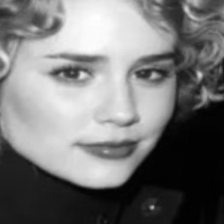

In [13]:
to_pil_transform = torchvision.transforms.ToPILImage()
to_pil_transform(dataset[42][1])

In [14]:
import psutil
psutil.cpu_count()

240

In [15]:
class PoptorchModel(nn.Module):
    def __init__(self, model, loss):
        super().__init__()
        self.model = model
        self.loss = loss

    def forward(self, xa, xp, xn):
        ya = self.model(xa)
        yp = self.model(xp)
        yn = self.model(xn)
        loss_data = self.loss(ya, yp, yn)
        return poptorch.identity_loss(loss_data, reduction='none')

def train_triplet_gc(model, dataset, num_epochs, lr=0.001, batch_size=16, gradient_accumulation=1, replication_factor=1):
    model.train()
    
    opts = poptorch.Options()
    if hw_emulation:
        opts.useIpuModel(True)
    opts.enableExecutableCaching(popcache_dir)
    opts.connectionType(poptorch.ConnectionType.OnDemand)
    opts.useIpuId(ipu_id)
    opts.Training.gradientAccumulation(gradient_accumulation)
    opts.replicationFactor(replication_factor)
    
    loss = torch.nn.TripletMarginLoss()
    loss_history = []
    print(f'lr: {lr}')
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    poptorch_model = poptorch.trainingModel(PoptorchModel(model, loss), options=opts, optimizer=optimizer)
    data_loader = poptorch.DataLoader(opts, dataset, batch_size=batch_size, num_workers=psutil.cpu_count())
    
    # run a batch to trigger compilation
    for xa, xp, xn in data_loader:
        poptorch_model(xa, xp, xn)
        break

    for epoch in range(1, num_epochs+1):
        loss_accum = 0
        loss_cnt = 0
        for xa, xp, xn in tqdm(data_loader, desc=f'train {epoch}/{num_epochs}'):
            loss_data = poptorch_model(xa, xp, xn)

            loss_accum += float(loss_data.mean())
            loss_cnt += 1
    
        loss_value = loss_accum / loss_cnt
        print(f'loss: {loss_value}')

        if loss_history and loss_value > loss_history[-1]:
            lr *= 0.1
            print(f'lr: {lr}')
            optimizer = optim.Adam(model.parameters(), lr=lr)
            poptorch_model.setOptimizer(optimizer)

        loss_history.append(loss_value)

    poptorch_model.detachFromDevice()
    return loss_history

In [16]:
def create_faceid_model():
    model = torchvision.models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 16)
    return model

def grayscale_fix_model(model):
    w = model.conv1.weight.data.sum(axis=1).reshape(64, 1, 7, 7)
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.conv1.weight.data = w
    return model

def set_trainable(model):
    model.requires_grad_(False)
    model.fc.requires_grad_(True)

model = create_faceid_model()
model = grayscale_fix_model(model)
set_trainable(model)
#summary(model)
model.conv1, model.fc

(Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Linear(in_features=2048, out_features=16, bias=True))

In [17]:
# finding best batch size
for i in range(4, 8):
    bs = 2**i
    try:
        print(f'Batch size: {bs} (2**{i})')
        model = create_faceid_model()
        model = grayscale_fix_model(model)
        set_trainable(model)
        train_triplet_gc(model, dataset, 0, batch_size=bs, replication_factor=2)
    except Exception as e:
        print(f'Exception: {e}')
        break

Batch size: 16 (2**4)
lr: 0.001


Graph compilation: 100%|██████████| 100/100 [00:03<00:00]


Batch size: 32 (2**5)
lr: 0.001


Graph compilation: 100%|██████████| 100/100 [04:39<00:00]


Exception: In poptorch/poptorch_err/include/poptorch_err/ExceptionHandling.hpp:76: 'popart_exception': /opt/jenkins/workspace/poplar/poplar_ci_ubuntu_20_04_unprivileged/popart/willow/src/popx/irlowering.cpp:3515 Out of memory on tile 0: 739180 bytes used but tiles only have 638976 bytes of memory
Error raised in:
  [0] popart::Session::prepareDevice: Poplar compilation
  [1] Compiler::compileAndPrepareDevice
  [2] LowerToPopart::compile
  [3] compileWithTrace



In [18]:
# finding best batch size
for i in range(1, 6):
    bs = 2**i
    try:
        print(f'Batch size: {bs} (2**{i})')
        model = create_faceid_model()
        model = grayscale_fix_model(model)
        train_triplet_gc(model, dataset, 0, batch_size=bs, gradient_accumulation=2)
    except Exception as e:
        print(f'Exception: {e}')
        break

Batch size: 2 (2**1)
lr: 0.001


Graph compilation: 100%|██████████| 100/100 [10:47<00:00]


Exception: In poptorch/poptorch_err/include/poptorch_err/ExceptionHandling.hpp:76: 'popart_exception': /opt/jenkins/workspace/poplar/poplar_ci_ubuntu_20_04_unprivileged/popart/willow/src/popx/irlowering.cpp:3515 Out of memory on tile 0: 829948 bytes used but tiles only have 638976 bytes of memory
Error raised in:
  [0] popart::Session::prepareDevice: Poplar compilation
  [1] Compiler::compileAndPrepareDevice
  [2] LowerToPopart::compile
  [3] compileWithTrace
  [4] popart::popx::Devicex::prepare()
  [5] popart::Session::prepareDevice(bool)
  [6] poptorch::Compiler::compileAndPrepareDevice()
  [7] poptorch::detail::LowerToPopartImpl::compile()
  [8] poptorch::LowerToPopart::compile()



In [19]:
model = create_faceid_model()
model = grayscale_fix_model(model)
set_trainable(model)

lr: 0.001


train 1/10: 100%|██████████| 7963/7963 [08:24<00:00, 15.80it/s]


loss: 0.4350590058369065


train 2/10: 100%|██████████| 7963/7963 [07:06<00:00, 18.65it/s]


loss: 0.2866625921024377


train 3/10: 100%|██████████| 7963/7963 [07:14<00:00, 18.34it/s]


loss: 0.24891147175416656


train 4/10: 100%|██████████| 7963/7963 [07:26<00:00, 17.82it/s]


loss: 0.23077210548548907


train 5/10: 100%|██████████| 7963/7963 [07:12<00:00, 18.42it/s]


loss: 0.22179804951266907


train 6/10: 100%|██████████| 7963/7963 [07:14<00:00, 18.32it/s]


loss: 0.21365701219970581


train 7/10: 100%|██████████| 7963/7963 [07:13<00:00, 18.35it/s]


loss: 0.20982721521393163


train 8/10: 100%|██████████| 7963/7963 [07:15<00:00, 18.27it/s]


loss: 0.207470517902612


train 9/10: 100%|██████████| 7963/7963 [07:20<00:00, 18.09it/s]


loss: 0.20659395600628735


train 10/10: 100%|██████████| 7963/7963 [07:19<00:00, 18.12it/s]


loss: 0.2046874590338766


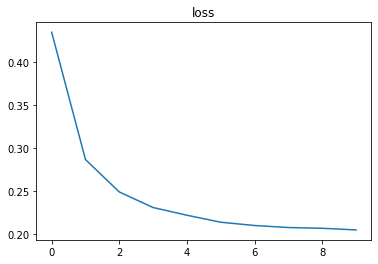

In [20]:
loss_history = train_triplet_gc(model, dataset, 10, batch_size=16, replication_factor=2)
plt.plot(loss_history)
plt.title('loss');

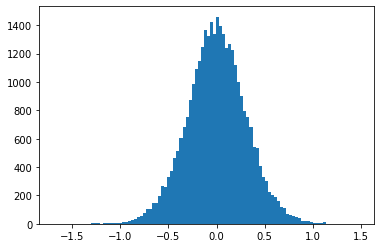

In [21]:
plt.hist(model.fc.weight.cpu().detach().reshape(-1), bins=100);

In [22]:
def cos_similarity(v1, v2):
    val = np.inner(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    return val.reshape(-1)[0]

def euc_similarity(v1, v2):
    return np.linalg.norm(v1-v2)

In [23]:
for i in range(10):
    v1 = model(dataset[42][0].reshape(1, 1, 224, 224)).cpu().detach().numpy()
    v2 = model(dataset[42][1].reshape(1, 1, 224, 224)).cpu().detach().numpy()
    v3 = model(dataset[42][2].reshape(1, 1, 224, 224)).cpu().detach().numpy()
    print(euc_similarity(v1, v2), euc_similarity(v1, v3),
          cos_similarity(v1, v2), cos_similarity(v1, v3),
          np.vstack((v1, v2, v3)).min(), np.vstack((v1, v2, v3)).max())

5.8993945 9.013541 0.75503176 0.34711385 -2.7923505 4.715359
7.365913 9.013541 0.57560897 0.34711385 -3.8654146 4.715359
7.432153 9.013541 0.52856076 0.34711385 -2.7923505 4.715359
7.328717 9.013541 0.5468705 0.34711385 -2.7923505 4.715359
6.2779875 9.013541 0.6979896 0.34711385 -2.7923505 4.715359
7.587626 9.013541 0.49867827 0.34711385 -2.7923505 4.715359
7.892968 9.013541 0.4631225 0.34711385 -2.7923505 4.715359
8.600538 9.013541 0.3253862 0.34711385 -2.7923505 4.715359
7.208788 9.013541 0.57635266 0.34711385 -2.7923505 4.715359
7.311114 9.013541 0.55752194 0.34711385 -2.7923505 4.715359


In [24]:
torch.save(model, f'faceid-model-{loss_history[-1]}.pt')

In [25]:
# reload - poptorch
state = model.state_dict()
model = create_faceid_model()
model = grayscale_fix_model(model)
model.load_state_dict(state)

<All keys matched successfully>

In [26]:
model.requires_grad_(True)
loss_history = train_triplet_gc(model, dataset, 5, lr=0.00001, batch_size=1, gradient_accumulation=2)
plt.plot(loss_history)
plt.title('loss');

lr: 1e-05


Graph compilation: 100%|██████████| 100/100 [13:40<00:00]


Error: In poptorch/poptorch_err/include/poptorch_err/ExceptionHandling.hpp:76: 'popart_exception': /opt/jenkins/workspace/poplar/poplar_ci_ubuntu_20_04_unprivileged/popart/willow/src/popx/irlowering.cpp:3515 Out of memory on tile 32: 649012 bytes used but tiles only have 638976 bytes of memory
Error raised in:
  [0] popart::Session::prepareDevice: Poplar compilation
  [1] Compiler::compileAndPrepareDevice
  [2] LowerToPopart::compile
  [3] compileWithTrace


In [ ]:
plt.hist(model.fc.weight.cpu().detach().reshape(-1), bins=100);

In [ ]:
for i in range(10):
    v1 = model(dataset[42][0].reshape(1, 1, 224, 224)).cpu().detach().numpy()
    v2 = model(dataset[42][1].reshape(1, 1, 224, 224)).cpu().detach().numpy()
    v3 = model(dataset[42][2].reshape(1, 1, 224, 224)).cpu().detach().numpy()
    print(euc_similarity(v1, v2), euc_similarity(v1, v3),
          cos_similarity(v1, v2), cos_similarity(v1, v3),
          np.vstack((v1, v2, v3)).min(), np.vstack((v1, v2, v3)).max())

In [ ]:
torch.save(model, f'faceid-model-{loss_history[-1]}.pt')
!ls -l faceid-model-*.pt